In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


Modelo Rede Neueral Convolucional U-Net



In [ ]:
import os
from sklearn.preprocessing import LabelEncoder
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
from PIL import Image
import tifffile as tiff


import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
from segmentation_models import Unet

# Prepare Data

In [ ]:
n_classes= 6 #Numero de classes

Importar imagens de treinamento

In [ ]:
def load_dataset(folder_path):
  # Importar e criar dataset de imagens
  file_name = glob.glob(f"{folder_path}/*.tif")
  file_name.sort()
  print(len(file_name))
  images = []
  for image in file_name:
      img = Image.open(image).convert('L')
      if img.size != (256, 256):
          print(image)
          print(img.size)
      images.append(np.array(img))
  image_dataset = np.array(images)
  return image_dataset

In [ ]:
# Importar Imagens de treinamento
train_image_dataset = load_dataset('/content/drive/MyDrive/segment_mafic/dataset/train_data/train_images')

276


In [ ]:
# Importar masks de treinamento
train_mask_dataset = load_dataset('/content/drive/MyDrive/segment_mafic/dataset/train_data/train_masks')

276


In [ ]:
unique_mask, mask_count = np.unique(train_mask_dataset, return_counts=True)

print("Image data shape is: ", train_image_dataset.shape)
print("Mask data shape is: ", train_mask_dataset.shape)
print("Max pixel value in image is: ", train_image_dataset.max())
print("Labels in the mask are : ", unique_mask)
print("Count of each label:", mask_count)
print("\n\n")
labelencoder = LabelEncoder()
n, h, w = train_mask_dataset.shape
mask_dataset_reshaped = train_mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

print(np.unique(mask_dataset_encoded))

#Normalizar o valor dos pixels das imagens, entre 0 e 1
image_dataset = train_image_dataset /255.

Image data shape is:  (276, 256, 256)
Mask data shape is:  (276, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5]
Count of each label: [ 342476  247390 5331412 6346830 1023986 4795842]





/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2 3 4 5]


Importar dados de Validação

In [ ]:
val_image_dataset = load_dataset('/content/drive/MyDrive/segment_mafic/dataset/val_data/val_images/')

168


In [ ]:
val_mask_dataset = load_dataset('/content/drive/MyDrive/segment_mafic/dataset/val_data/val_masks')

168


In [ ]:
unique_mask, mask_count = np.unique(val_mask_dataset, return_counts=True)

print("Validation image data shape is: ", val_image_dataset.shape)
print("Validartion mask data shape is: ", val_mask_dataset.shape)
print("Max pixel value in image is: ", val_image_dataset.max())
print("Labels in the mask are : ", unique_mask)
print("Count of each label:", mask_count)
print("\n\n")
labelencoder = LabelEncoder()
n, h, w = val_mask_dataset.shape
val_mask_dataset_reshaped = val_mask_dataset.reshape(-1,1)
val_mask_dataset_reshaped_encoded = labelencoder.fit_transform(val_mask_dataset_reshaped)
val_mask_dataset_encoded = val_mask_dataset_reshaped_encoded.reshape(n, h, w)

print(np.unique(val_mask_dataset_encoded))

#Normalizar o valor dos pixels das imagens, entre 0 e 1
val_image_dataset = val_image_dataset /255.

Validation image data shape is:  (168, 256, 256)
Validartion mask data shape is:  (168, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5]
Count of each label: [ 222102  149337 3257586 3739910  740718 2900395]





/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2 3 4 5]


In [ ]:
X_train = image_dataset
X_val = val_image_dataset
y_train = mask_dataset_encoded
y_val = val_mask_dataset_encoded

In [ ]:
print(X_train.shape)
print(X_val.shape)

(276, 256, 256)
(168, 256, 256)


*Sanity check*, verificar alguns pares de imagens e masks


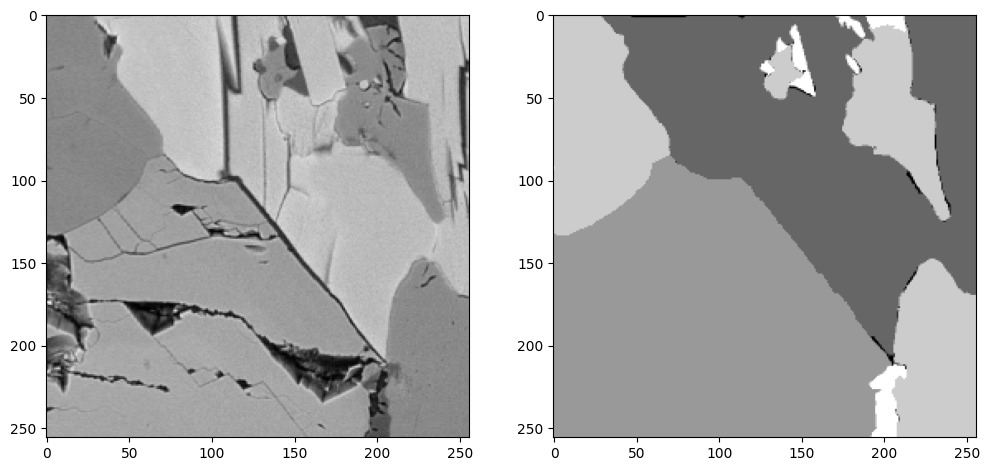

In [ ]:
import random
import numpy as np

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

# Create Model

Transformar os dados em categóricos


In [ ]:
from tensorflow.keras.utils import to_categorical
n_classes = 6
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [ ]:
print(train_masks_cat.shape)
print(y_train_cat.shape)

print(np.unique(val_masks_cat))
print(val_masks_cat.shape)
print(y_val_cat.shape)

(276, 256, 256, 6)
(276, 256, 256, 6)
[0. 1.]
(168, 256, 256, 6)
(168, 256, 256, 6)


## Unet Model

In [ ]:
# Building Unet by dividing encoder and decoder into blocks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters): # Duas convoluções
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)   # ReLu como função de ativação

    return x


#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters) # gerar features
    p = MaxPool2D((2, 2))(x)    # Reduz as imagens a aprtir de um kernel 2x2
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])   # utiliza a posição dos pixels do encoder
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    #Change the activation based on n_classes
    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:               # mulsti-class classification
      activation = 'softmax'

    # Output convolution
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Train

Gerar pessos para as classes

>    Mal sucedido ao usar (até o momento)




In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                classes = np.unique(mask_dataset_reshaped_encoded),
                                                y = mask_dataset_reshaped_encoded)
print("Class weights are:", class_weights)

Class weights are: [ 8.47919622 14.18909395  0.52019404  0.45368964  3.66087643  0.70825571]


Transformar as classes de listas para dicionários

In [ ]:
class_weights2 = class_weights
lista = [0,1,2,3,4,5]
classWeights = dict(zip(lista, class_weights2))
print(classWeights)

{0: 8.479196223822399, 1: 14.189093949710326, 2: 0.5201940370529425, 3: 0.45368963716172794, 4: 3.660876432630261, 5: 0.7082557114721353}


In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 1)


In [ ]:
model = build_unet(input_shape, n_classes)
model.compile(optimizer='adam', # Adam como otimizador que utiliza backpropagation
              loss='categorical_crossentropy', # Função de custo # para classificação binária usar binary_crossentropy
              metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 16,
                    verbose=1,
                    epochs=120,
                    validation_data=(X_val, y_val_cat),
                    #class_weight=classWeights,
                    shuffle=True,
                    )

Epoch 1/120
18/18 [==============================] - 82s 2s/step - loss: 0.7245 - accuracy: 0.7890 - val_loss: 526.1113 - val_accuracy: 0.0139
Epoch 2/120
18/18 [==============================] - 19s 1s/step - loss: 0.3618 - accuracy: 0.9016 - val_loss: 9.2512 - val_accuracy: 0.1993
Epoch 3/120
18/18 [==============================] - 17s 957ms/step - loss: 0.3781 - accuracy: 0.8881 - val_loss: 181.7507 - val_accuracy: 0.3397
Epoch 4/120
18/18 [==============================] - 17s 967ms/step - loss: 0.3170 - accuracy: 0.9062 - val_loss: 4.1814 - val_accuracy: 0.1486
Epoch 5/120
18/18 [==============================] - 20s 1s/step - loss: 0.2752 - accuracy: 0.9164 - val_loss: 57.1290 - val_accuracy: 0.3837
Epoch 6/120
18/18 [==============================] - 20s 1s/step - loss: 0.2686 - accuracy: 0.9169 - val_loss: 8.1508 - val_accuracy: 0.3605
Epoch 7/120
18/18 [==============================] - 17s 975ms/step - loss: 0.2633 - accuracy: 0.9169 - val_loss: 6.4571 - val_accuracy: 0.1316

In [ ]:
print(X_val.shape)
print(y_val_cat.shape)

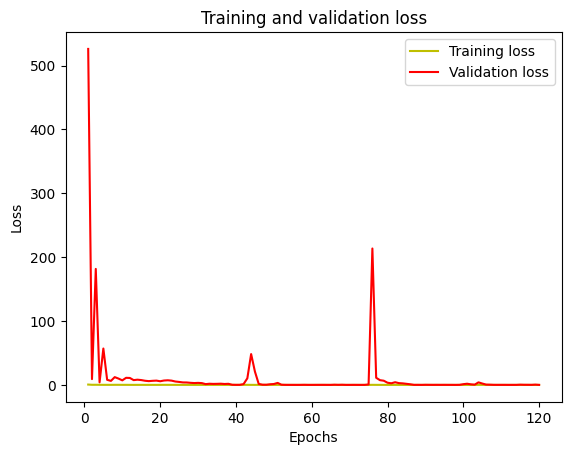

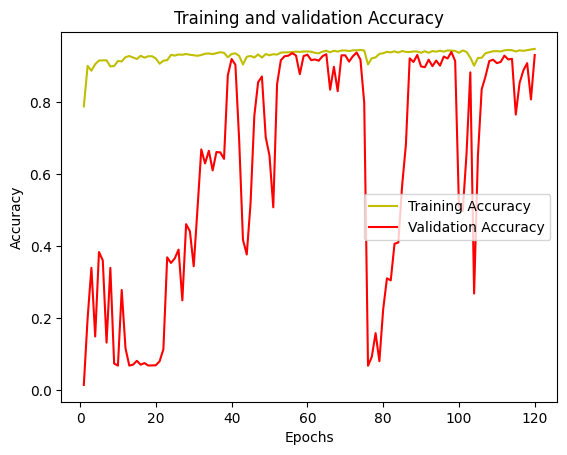

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

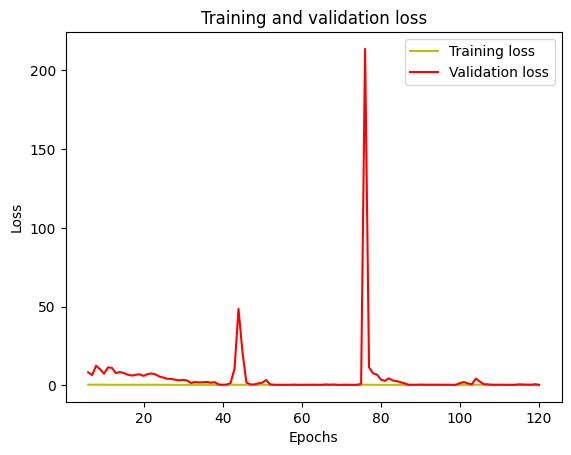

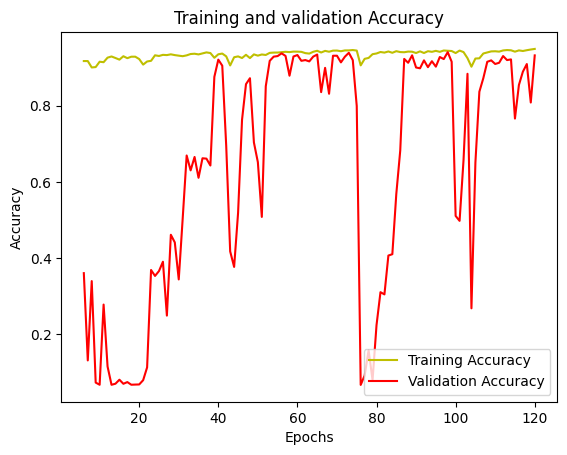

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(6, len(loss) + 1)  # Ajustando o intervalo de epochs

plt.plot(epochs, loss[5:], 'y', label='Training loss')
plt.plot(epochs, val_loss[5:], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc[5:], 'y', label='Training Accuracy')
plt.plot(epochs, val_acc[5:], 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/segment_mafic/model_11_08.hdf5')

# Load & Test Model

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/segment_mafic/model_11_08.hdf5')

In [ ]:
# load test data
test_image_dataset = load_dataset('/content/drive/MyDrive/segment_mafic/dataset/test_data/test_images')
test_mask_dataset = load_dataset('/content/drive/MyDrive/segment_mafic/dataset/test_data/test_masks')

72
72


In [ ]:
unique_mask, mask_count = np.unique(test_mask_dataset, return_counts=True)

print("Test image data shape is: ", test_image_dataset.shape)
print("Test mask data shape is: ", test_mask_dataset.shape)
print("Max pixel value in image is: ", test_image_dataset.max())
print("Labels in the mask are : ", unique_mask)
print("Count of each label:", mask_count)
print("\n\n")

labelencoder = LabelEncoder()
n, h, w = test_mask_dataset.shape
test_mask_dataset_reshaped = test_mask_dataset.reshape(-1,1)
test_mask_dataset_reshaped_encoded = labelencoder.fit_transform(test_mask_dataset_reshaped)
test_mask_dataset_encoded = test_mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(test_mask_dataset_encoded)

#Normalizar o valor dos pixels das imagens, entre 0 e 1
test_image_dataset = test_image_dataset /255.

Test image data shape is:  (72, 256, 256)
Test mask data shape is:  (72, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5]
Count of each label: [ 127360   64498 1325846 1427788  587252 1185848]





/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X_test = test_image_dataset
y_test = test_mask_dataset_encoded

In [ ]:
y_pred=model.predict(X_test)
print(y_pred.shape)

y_pred_argmax=np.argmax(y_pred, axis=3)
print(y_pred_argmax.shape)

3/3 [==============================] - 20s 294ms/step
(72, 256, 256, 6)
(72, 256, 256)


Testar algumas predições

1/1 [==============================] - 0s 22ms/step


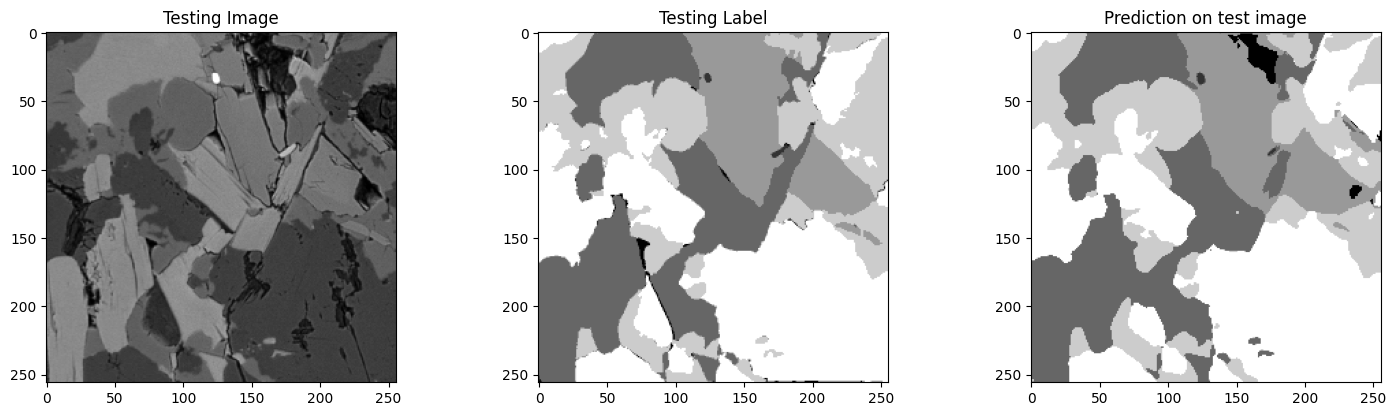

In [ ]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(18, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()

# Métricas

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = n_classes
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.71982986


IoU de cada mineral

In [ ]:
#To calculate I0U for 6 classes
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
#print(values)

class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4]+ values[0,5]+ values[1,0]+ values[2,0]+ values[3,0]+ values[4,0]+ values[5,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4]+ values[1,5]+ values[0,1]+ values[2,1]+ values[3,1]+ values[4,1]+ values[5,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4]+ values[2,5]+ values[0,2]+ values[1,2]+ values[3,2]+ values[4,2]+ values[5,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4]+ values[3,5]+ values[0,3]+ values[1,3]+ values[2,3]+ values[4,3]+ values[5,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3]+ values[4,5]+ values[0,4]+ values[1,4]+ values[2,4]+ values[3,4]+ values[5,4])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3]+ values[5,4]+ values[0,5]+ values[1,5]+ values[2,5]+ values[3,5]+ values[4,5])

print("IoU para o fundo is: ", class1_IoU)
print("IoU para titanita is: ", class2_IoU)
print("IoU para biotita is: ", class3_IoU)
print("IoU para anfibólio is: ", class4_IoU)
print("IoU para k-feldspato is: ", class5_IoU)
print("IoU para plagioclásio is: ", class6_IoU)

IoU para o fundo is:  0.25796443
IoU para titanita is:  0.6058049
IoU para biotita is:  0.8586616
IoU para anfibólio is:  0.8617131
IoU para k-feldspato is:  0.8312806
IoU para plagioclásio is:  0.9035548


Confusion Matrix

In [ ]:
y_test_lin = y_test.ravel()
y_pred_lin = y_pred_argmax.ravel()

print(y_test_lin.shape)
print(y_pred_lin.shape)
print(np.unique(y_test_lin))
print(np.unique(y_pred_lin))

(4718592,)
(4718592,)
[0 1 2 3 4 5]
[0 1 2 3 4 5]


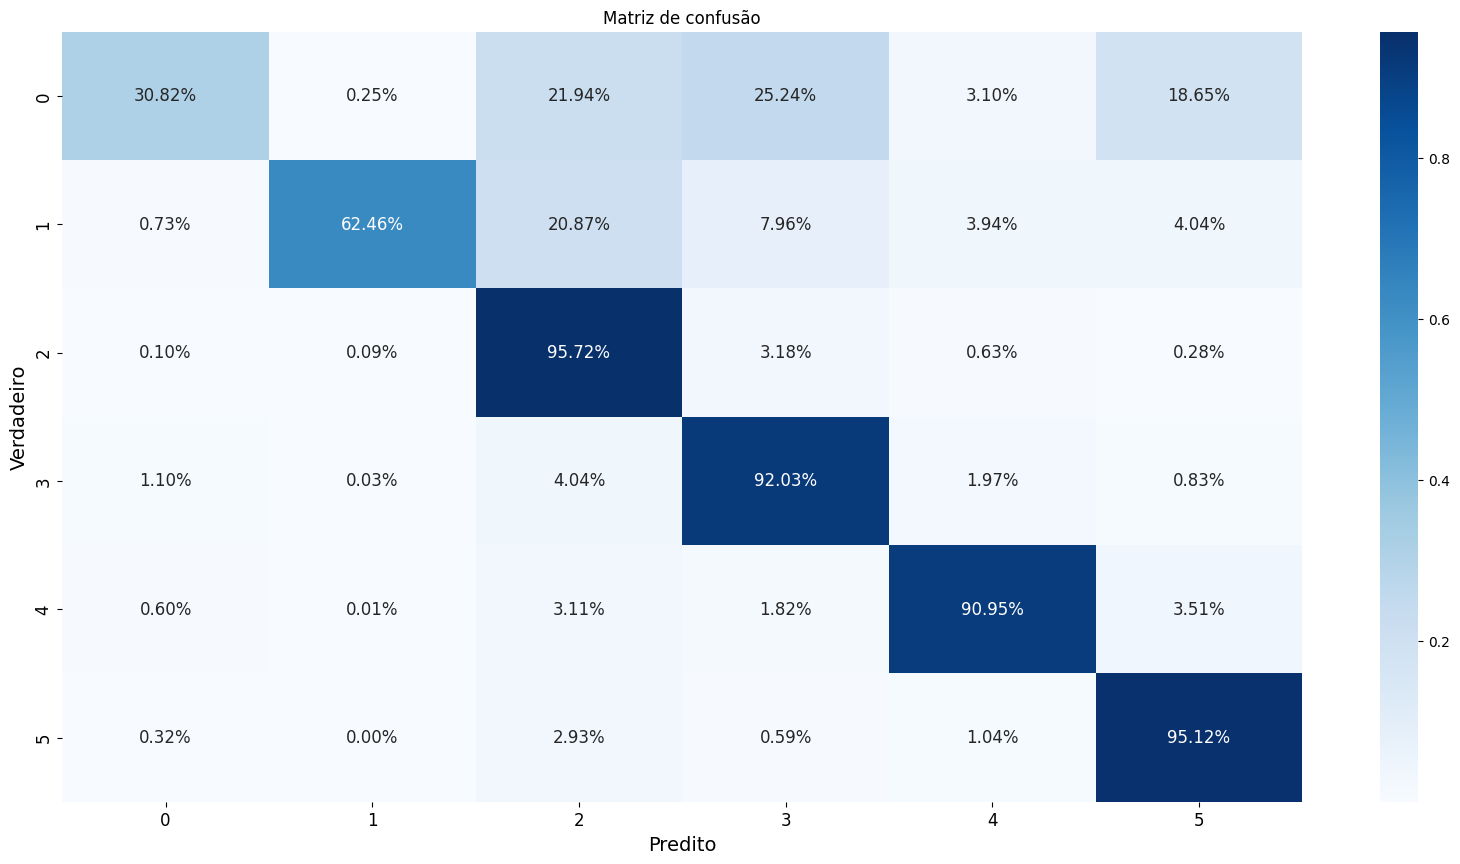

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = np.unique(y_pred_lin)
cm = confusion_matrix(y_test_lin, y_pred_lin, labels=labels)

# Converter a matriz de contagem em porcentagem
cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 10))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues", annot_kws={"fontsize": 12})

plt.xticks(fontsize=12)  # Aumentar o tamanho da fonte para os valores do eixo x
plt.yticks(fontsize=12)  # Aumentar o tamanho da fonte para os valores do eixo y


plt.xlabel('Predito', fontsize=14)
plt.ylabel('Verdadeiro', fontsize=14)

plt.title('Matriz de confusão')

plt.show()


In [ ]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print(y_pred[:,:,:,0].shape)
print(y_test_cat[:,:,:,0].shape)

(72, 256, 256)
(72, 256, 256)


ROC curves

In [ ]:
#ROC
from sklearn.metrics import roc_curve

y_test_lin0 = y_test_cat[:,:,:,0].ravel()
y_pred_lin0 = y_pred[:,:,:,0].ravel()
fpr0, tpr0, thresholds0 = roc_curve(y_test_lin0, y_pred_lin0)

y_test_lin1 = y_test_cat[:,:,:,1].ravel()
y_pred_lin1 = y_pred[:,:,:,1].ravel()
fpr1, tpr1, thresholds1 = roc_curve(y_test_lin1, y_pred_lin1)

y_test_lin2 = y_test_cat[:,:,:,2].ravel()
y_pred_lin2 = y_pred[:,:,:,2].ravel()
fpr2, tpr2, thresholds2 = roc_curve(y_test_lin2, y_pred_lin2)

y_test_lin3 = y_test_cat[:,:,:,3].ravel()
y_pred_lin3 = y_pred[:,:,:,3].ravel()
fpr3, tpr3, thresholds3 = roc_curve(y_test_lin3, y_pred_lin3)

y_test_lin4 = y_test_cat[:,:,:,4].ravel()
y_pred_lin4 = y_pred[:,:,:,4].ravel()
fpr4, tpr4, thresholds4 = roc_curve(y_test_lin4, y_pred_lin4)

y_test_lin5 = y_test_cat[:,:,:,5].ravel()
y_pred_lin5 = y_pred[:,:,:,5].ravel()
fpr5, tpr5, thresholds5 = roc_curve(y_test_lin5, y_pred_lin5)


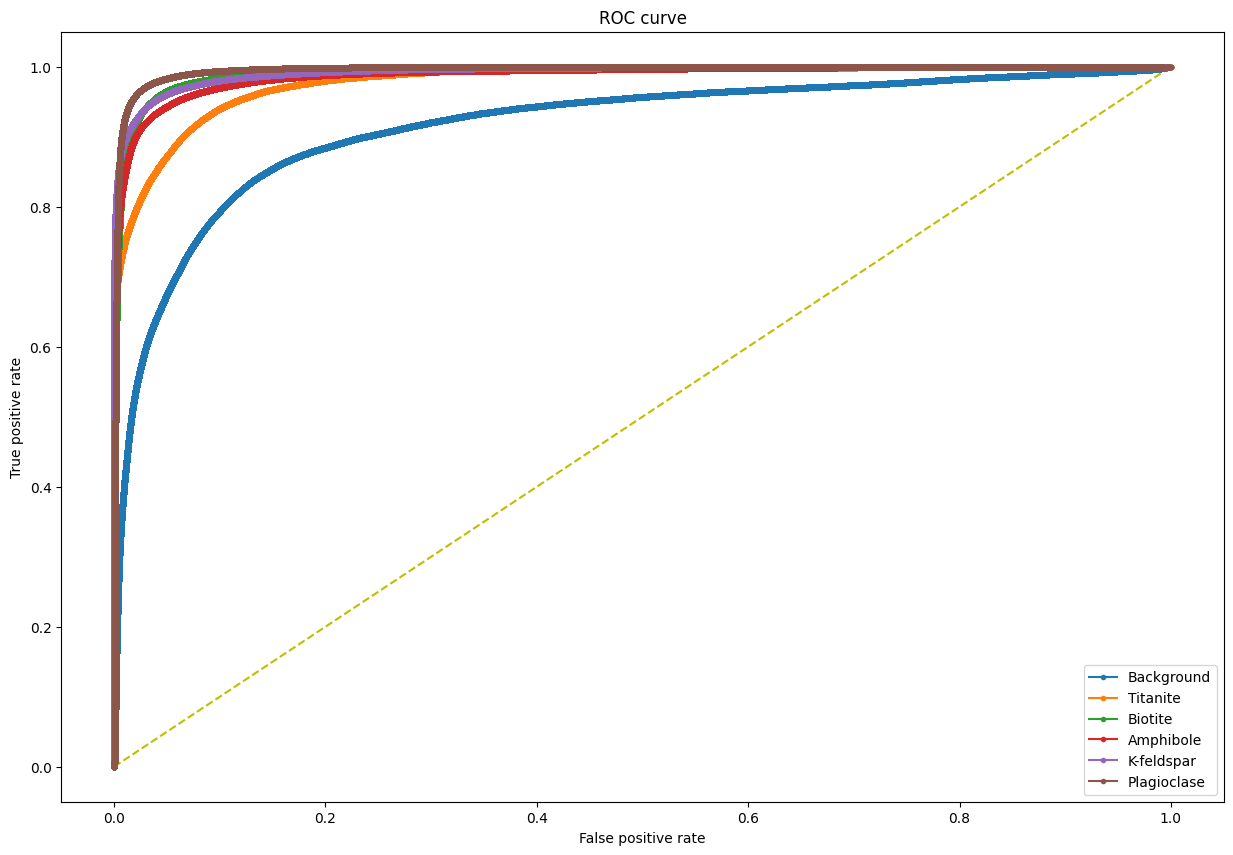

In [ ]:
#Plotting

plt.figure(1, figsize=(15,10))
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr0, tpr0, marker='.', label='Background')
plt.plot(fpr1, tpr1, marker='.', label='Titanite')
plt.plot(fpr2, tpr2, marker='.', label='Biotite')
plt.plot(fpr3, tpr3, marker='.', label='Amphibole')
plt.plot(fpr4, tpr4, marker='.', label='K-feldspar')
plt.plot(fpr5, tpr5, marker='.', label='Plagioclase')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

AUC

In [ ]:
from sklearn.metrics import roc_auc_score

auc0 = roc_auc_score(y_test_lin0, y_pred_lin0)
auc1 = roc_auc_score(y_test_lin1, y_pred_lin1)
auc2 = roc_auc_score(y_test_lin2, y_pred_lin2)
auc3 = roc_auc_score(y_test_lin3, y_pred_lin3)
auc4 = roc_auc_score(y_test_lin4, y_pred_lin4)
auc5 = roc_auc_score(y_test_lin5, y_pred_lin5)

print("AUC-ROC for Class 0:", auc0)
print("AUC-ROC for Class 1:", auc1)
print("AUC-ROC for Class 2:", auc2)
print("AUC-ROC for Class 3:", auc3)
print("AUC-ROC for Class 4:", auc4)
print("AUC-ROC for Class 5:", auc5)

AUC-ROC for Class 0: 0.9156116669746676
AUC-ROC for Class 1: 0.9794258689918381
AUC-ROC for Class 2: 0.9916996524261416
AUC-ROC for Class 3: 0.9877208929173018
AUC-ROC for Class 4: 0.9923017931223259
AUC-ROC for Class 5: 0.995139590682341


Outras metricas

In [ ]:
import numpy as np
from keras.metrics import MeanIoU
from keras.metrics import Precision, Recall
from keras.metrics import Accuracy
from keras.metrics import binary_accuracy
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical

# Função para calcular a métrica Intersection over Union (IoU)
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Função para calcular o coeficiente DICE
def calculate_dice(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice = 2.0 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

In [ ]:
# Converte as máscaras para one-hot encoding
y_true = to_categorical(y_test_cat, num_classes=6)
y_pred = to_categorical(y_pred, num_classes=6)

# Número de classes
num_classes = y_true.shape[2]


In [ ]:
# Calcula as métricas para o modelo
iou = calculate_iou(y_true, y_pred)
dice = calculate_dice(y_true, y_pred)

In [ ]:
# Métricas do Keras
mean_iou = MeanIoU(num_classes=num_classes)
mean_iou.update_state(y_true, y_pred)
precision = Precision()
precision.update_state(y_true, y_pred)
recall = Recall()
recall.update_state(y_true, y_pred)
accuracy = Accuracy()
accuracy.update_state(y_true, y_pred)
binary_acc = binary_accuracy(y_true, y_pred)
categorical_acc = categorical_accuracy(y_true, y_pred)

In [ ]:
# Exibe as métricas calculadas para o modelo
print("Model Metrics:")
print("IoU:", iou)
print("DICE Coefficient:", dice)
print("Mean IoU (Keras):", mean_iou.result().numpy())
print("Precision (Keras):", precision.result().numpy())
print("Recall (Keras):", recall.result().numpy())
print("Accuracy (Keras):", accuracy.result().numpy())
#print("Binary Accuracy (Keras):", binary_acc.numpy())
#print("Categorical Accuracy (Keras):", categorical_acc.numpy())

Model Metrics:
IoU: 0.7142857142857143
DICE Coefficient: 0.8333333333333334
Mean IoU (Keras): 0.64
Precision (Keras): 0.8333333
Recall (Keras): 0.8333333
Accuracy (Keras): 0.9444444


In [62]:
pip install tf2onnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26


In [65]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tf2onnx

# Carregar modelo a partir do arquivo HDF5
hdf5_model = load_model('/content/drive/MyDrive/segment_mafic/model_11_08.hdf5')  # Substitua pelo nome do arquivo HDF5

# Converter o modelo Keras para grafo TensorFlow
onnx_model, _ = tf2onnx.convert.from_keras(hdf5_model)

# Salvar o modelo ONNX em um arquivo
with open('/content/drive/MyDrive/segment_mafic/maficRock_segmentation.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())
